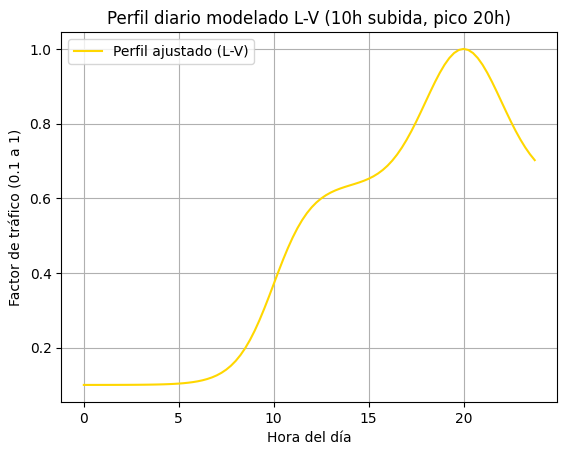

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tiempo en intervalos de 15 minutos
tiempo = np.arange(0, 24, 0.25)  # 96 puntos

# Función modificada con crecimiento desde 10am y pico en 8pm
def perfil_pico_valle_doble(t):
    # Crecimiento desde 10am (hora 10)
    subida = 1 / (1 + np.exp(-(t - 10)))  # sigmoide con centro en 10am

    # Pico principal como campana gaussiana centrada en 8pm (hora 20)
    pico = np.exp(-0.5 * ((t - 20) / 2) ** 2)  # desviación estándar = 2

    # Combinación ponderada de ambas curvas
    combinado = 0.6 * subida + 0.4 * pico

    # Normalizar y escalar entre 0.1 y 1.0
    normalizado = combinado / np.max(combinado)
    return 0.1 + 0.9 * normalizado

# Generar valores y tabla
valores_modelados = perfil_pico_valle_doble(tiempo)
tabla_modelada = pd.DataFrame({
    'Hora': tiempo,
    'Factor_LV': np.round(valores_modelados, 4)
})

# Graficar
plt.plot(tiempo, valores_modelados, label="Perfil ajustado (L-V)", color='gold')
plt.title("Perfil diario modelado L-V (10h subida, pico 20h)")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico (0.1 a 1)")
plt.grid(True)
plt.legend()
plt.show()


In [206]:
def generar_curva_con_ruido(factor_base, ruido_std=0.000001, seed=None):
    np.random.seed(seed)
    ruido = np.random.normal(0, ruido_std, size=len(factor_base))
    curva = factor_base + ruido
    curva = np.clip(curva, 0.0001, 1.0)  # límite inferior y superior
    return curva


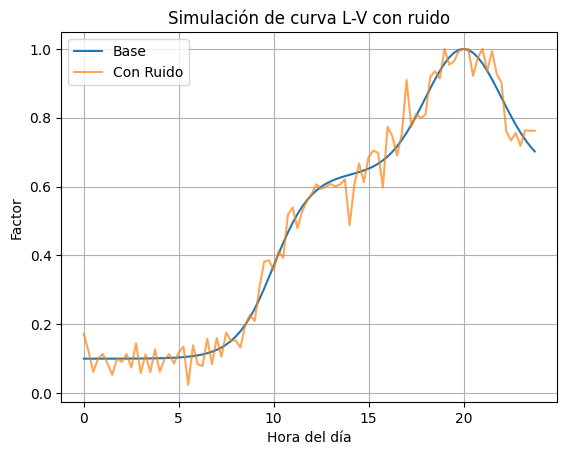

In [207]:
curva_simulada = generar_curva_con_ruido(tabla_modelada['Factor_LV'].values, ruido_std=0.05)

plt.plot(tiempo, tabla_modelada['Factor_LV'], label="Base")
plt.plot(tiempo, curva_simulada, label="Con Ruido", alpha=0.7)
plt.legend()
plt.title("Simulación de curva L-V con ruido")
plt.xlabel("Hora del día")
plt.ylabel("Factor")
plt.grid(True)
plt.show()

In [208]:
def estimador_trafico(hora_decimal, ruido=True, ruido_max=0.002, seed=None):
    """
    Devuelve el factor de tráfico estimado para una hora decimal, con opción de ruido.
    - hora_decimal: hora en formato flotante (p. ej. 13.75 = 13:45).
    - ruido: si True, se agrega un pequeño ruido aleatorio ±ruido_max.
    - seed: para reproducibilidad del ruido, usar un entero.
    """
    # Normalizar hora entre 0 y 24
    hora_normalizada = hora_decimal % 24

    # Recalcular perfil base
    tiempo = np.arange(0, 24, 0.25)
    perfil = perfil_pico_valle_doble(tiempo)

    # Valor interpolado
    valor_estimado = np.interp(hora_normalizada, tiempo, perfil)

    # Aplicar ruido si se solicita
    if ruido:
        if seed is not None:
            np.random.seed(seed)
        delta = np.random.uniform(-ruido_max, ruido_max)
        valor_estimado += delta

    # Limitar a rango permitido
    return np.clip(valor_estimado, 0.1, 1.0)


In [209]:
for hora in [9.75, 13.25, 20.0, 23.75, 26.0]:
    valor = estimador_trafico(hora, ruido=True)
    print(f"Hora {hora:.2f} -> Factor estimado con ruido: {valor:.4f}")


Hora 9.75 -> Factor estimado con ruido: 0.3351
Hora 13.25 -> Factor estimado con ruido: 0.6207
Hora 20.00 -> Factor estimado con ruido: 1.0000
Hora 23.75 -> Factor estimado con ruido: 0.7016
Hora 26.00 -> Factor estimado con ruido: 0.1000


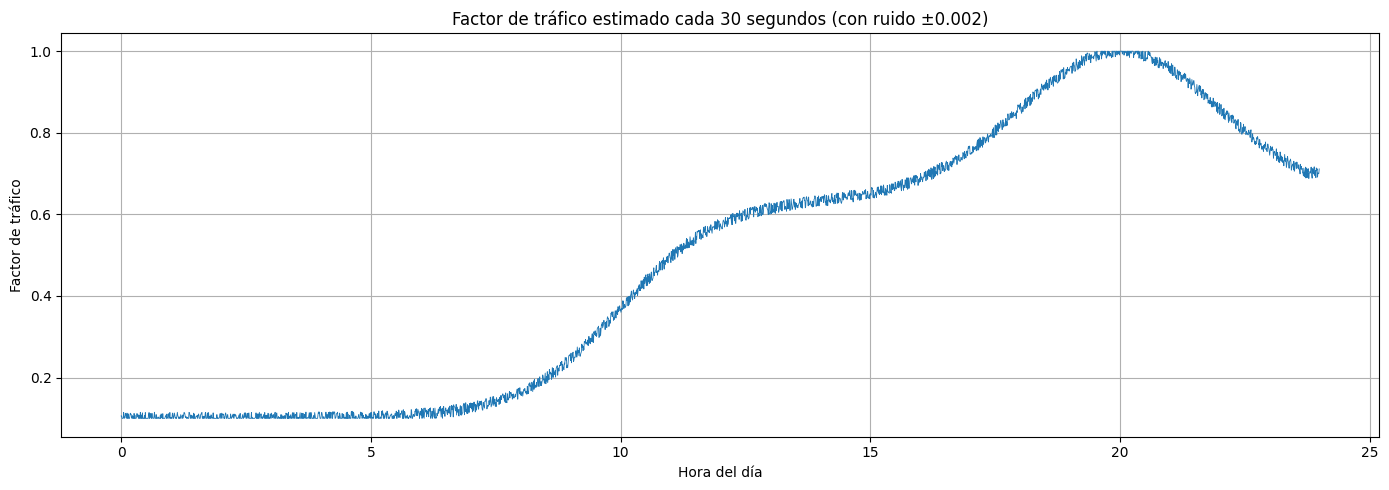

In [210]:
# Generar tiempos cada 30 segundos (1/120 de hora)
resolucion_segundos = 30
intervalo_horas = resolucion_segundos / 3600  # = 1/120
tiempos = np.arange(0, 24, intervalo_horas)  # 2880 puntos

# Evaluar factor de tráfico para cada punto con ruido
factores = [estimador_trafico(t, ruido=True, ruido_max=0.015) for t in tiempos]

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(tiempos, factores, lw=0.6)
plt.title("Factor de tráfico estimado cada 30 segundos (con ruido ±0.002)")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.grid(True)
plt.tight_layout()
plt.show()

In [211]:
from model.TrafficModel import  estimate_traffic_from_seconds

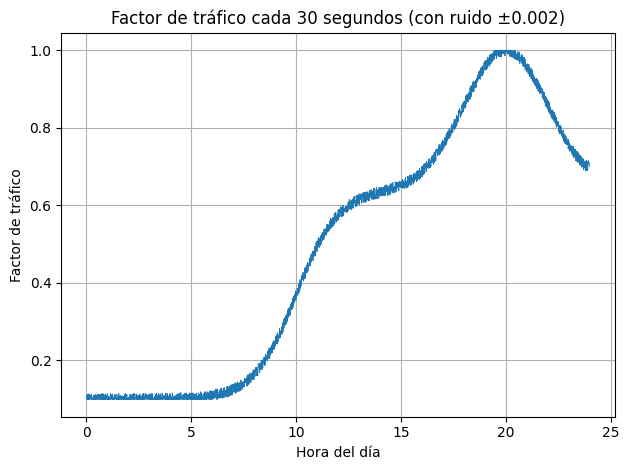

In [212]:
# Simular tráfico cada 30 segundos durante 1 día
t_segundos = np.arange(0, 24*3600, 30)
factores = [estimate_traffic_from_seconds(t) for t in t_segundos]

# Graficar
horas_decimal = t_segundos / 3600
plt.plot(horas_decimal, factores, lw=0.6)
plt.title("Factor de tráfico cada 30 segundos (con ruido ±0.002)")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.grid(True)
plt.tight_layout()
plt.show()


# Tests para nueva función normal

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [251]:
# Tiempo en intervalos de 15 minutos
alpha = 0.2
offset = 0.1


def f_gaussiana_base(t, _sigma=4*3600, _mu=12*3600):
    return 1 - np.exp(-((t - _mu)**2) / (2 * _sigma**2))

def f_gaussiana_pico(t, _sigma=1*3600, _mu=20*3600):
    return np.exp(-0.5 * ((t - _mu - 6*3600) / _sigma) ** 2)



# Función modificada con crecimiento desde 10am y pico en 8pm
def valley_peak_traffic_profile(t_segundos, _alpha=0.2, _offset=0.2):
    """
    Devuelve el perfil de tráfico evaluado para tiempo en segundos.
    """
    t_horas = t_segundos / 3600.0

    # Función siunoidal
    # return alpha + (1 - alpha) * (np.sin(t_horas * np.pi / 24) ** 2)

    # Función normal complementaria
    return _offset + (1 - _offset) * (
            f_gaussiana_base(t_segundos)
    )

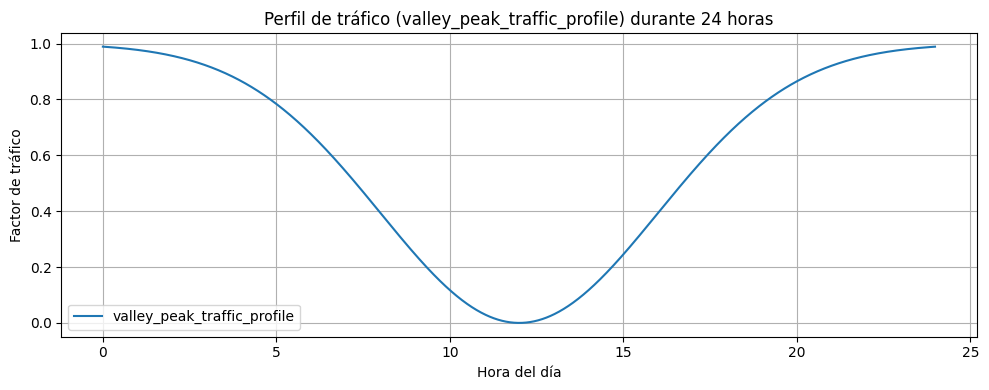

In [252]:
# Graficar la función valley_peak_traffic_profile para 24 horas (en segundos)
t_segundos_plot = np.arange(0, 24*3600, 60)  # cada minuto
valores = f_gaussiana_base(t_segundos_plot)

plt.figure(figsize=(10,4))
plt.plot(t_segundos_plot / 3600, valores, label="valley_peak_traffic_profile")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.title("Perfil de tráfico (valley_peak_traffic_profile) durante 24 horas")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

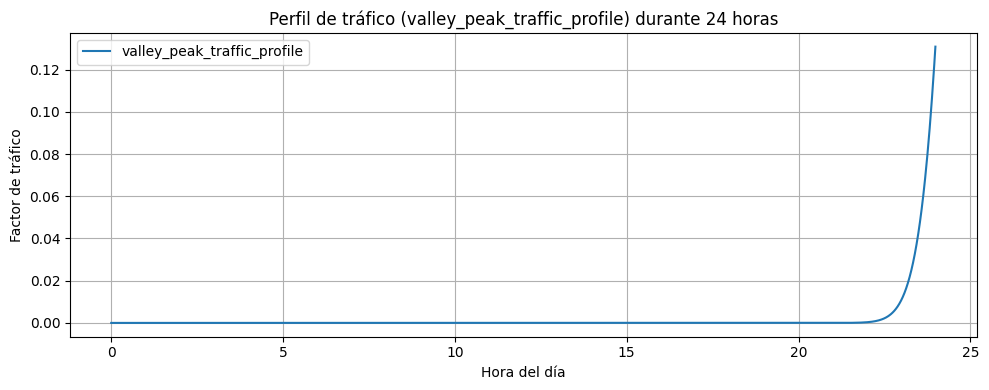

In [253]:
# Graficar la función valley_peak_traffic_profile para 24 horas (en segundos)
t_segundos_plot = np.arange(0, 24*3600, 60)  # cada minuto
valores = f_gaussiana_pico(t_segundos_plot)

plt.figure(figsize=(10,4))
plt.plot(t_segundos_plot / 3600, valores, label="valley_peak_traffic_profile")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.title("Perfil de tráfico (valley_peak_traffic_profile) durante 24 horas")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

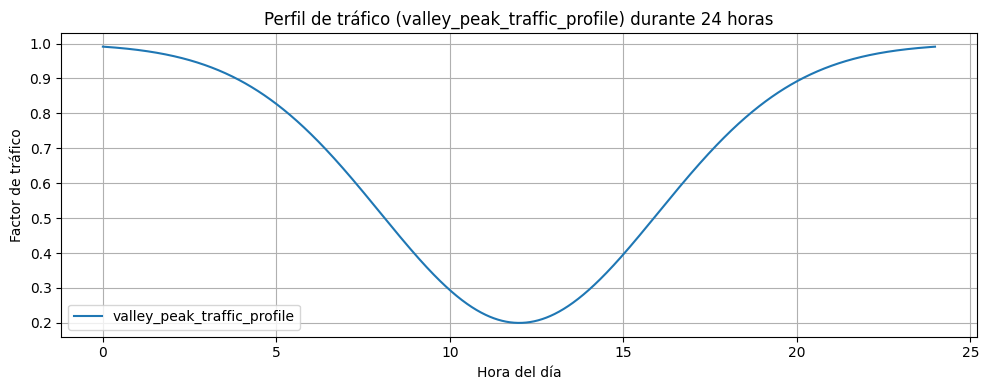

In [254]:
# Graficar la función valley_peak_traffic_profile para 24 horas (en segundos)
t_segundos_plot = np.arange(0, 24*3600, 60)  # cada minuto
valores = valley_peak_traffic_profile(t_segundos_plot)

plt.figure(figsize=(10,4))
plt.plot(t_segundos_plot / 3600, valores, label="valley_peak_traffic_profile")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.title("Perfil de tráfico (valley_peak_traffic_profile) durante 24 horas")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [255]:
def f_gaussiana_base(t, _sigma=4*3600, _mu=12*3600):
    return 1 - np.exp(-((t - _mu)**2) / (2 * _sigma**2))

def f_gaussiana_pico(t, _sigma=1*3600, _mu=20*3600):
    return np.exp(-0.5 * ((t - _mu) / _sigma) ** 2)



def estimate_traffic_from_seconds(t_segundos, ruido=True, ruido_max=0.015, seed=None):
    """
    Devuelve el factor de tráfico para un instante temporal dado en segundos.
    Usa interpolación con resolución de 15 minutos (900s) y ruido opcional.
    """
    # Desplazamos el tiempo 6 horas hacia adelante, para ajustar el valle de la función
    t_segundos = t_segundos + 6 * 3600

    # Normalizar el tiempo al rango de un día
    t_segundos_norm = t_segundos % (24 * 3600)  # segundos en un día

    # Crear vector base de referencia (cada 15 minutos = 900s)
    tiempos_base = np.arange(0, 24 * 3600, 900)
    perfil_base = valley_peak_traffic_profile(tiempos_base)

    # Interpolación
    valor_estimado = np.interp(t_segundos_norm, tiempos_base, perfil_base)

    # Aplicar ruido
    if ruido:
        if seed is not None:
            np.random.seed(seed)
        delta = np.random.uniform(-ruido_max, ruido_max)
        valor_estimado += delta

    # return np.clip(valor_estimado, 0.1, 1.0)
    return valor_estimado


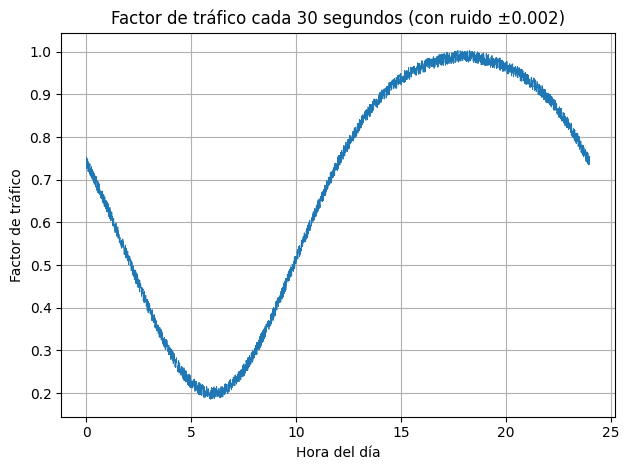

In [256]:
# Simular tráfico cada 30 segundos durante 1 día
t_segundos = np.arange(0, 24*3600, 30)
factores = [estimate_traffic_from_seconds(t) for t in t_segundos]

# Graficar
horas_decimal = t_segundos / 3600
plt.plot(horas_decimal, factores, lw=0.6)
plt.title("Factor de tráfico cada 30 segundos (con ruido ±0.002)")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.grid(True)
plt.tight_layout()
plt.show()



# Prueba Gausiana

In [257]:
import numpy as np

def uno_menos_gaussiana(x, A=1.0, mu=0.0, sigma=1.0):
    """
    Retorna 1 menos una gaussiana con parámetros A (amplitud), mu (media) y sigma (desviación estándar).

    Parámetros:
    x     : valor o array de valores donde evaluar la función
    A     : amplitud de la gaussiana
    mu    : media de la gaussiana
    sigma : desviación estándar de la gaussiana
    """
    return 1 - A * np.exp(-((x - mu)**2) / (2 * sigma**2))


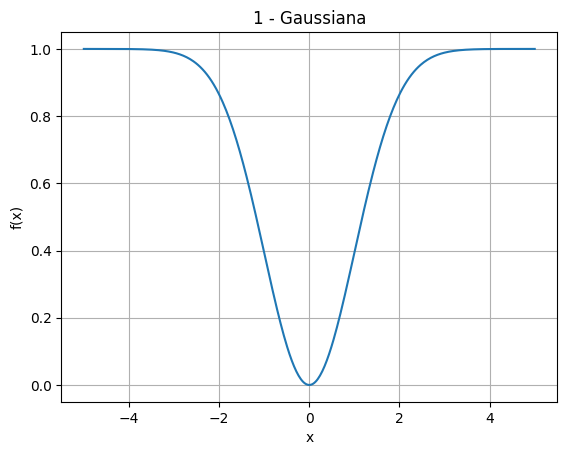

In [258]:
import matplotlib.pyplot as plt

x_vals = np.linspace(-5, 5, 400)
y_vals = uno_menos_gaussiana(x_vals, A=1.0, mu=0.0, sigma=1.0)

plt.plot(x_vals, y_vals)
plt.title("1 - Gaussiana")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()
